<a href="https://colab.research.google.com/github/clarakl/UoA-GEOG761/blob/main/761_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Welcome to Lab 2, in this lab we will take our first steps into applying ML to satellite data, using landcover analysis as our primary goal.

As covered in Lecture 2, landcover classification is the quintessential remote sensing task in the civil sector. The LandSat programme was originally developed in large part to enable the USA to monitor landcover more easily for a range of agricultral, govermental and finacial problemsets. It remains a primary task for governments and companies around the world.

This is a pixel-wise ML task. We will apply two methods, both of which are available in GEE as ready-to-go algorithms. In this instance we are happy to go with built-in as it allows us to become familiar with an end-to-end GEE ML workflow without getting bogged down in technical detail. No need to re-invent the wheel unless you are going to the [moon](https://www.nasa.gov/feature/ames/artemis-moon-rover-s-wheels-are-ready-to-roll/).

Remember that this is a set of exercises and tutorials that escalate in difficulty. Always show your working and do not neccesarily expect to get full marks on everything.

Use the resources available to you outside of this material. I expect you to search for concepts or terms you do not understand and to look at the documentation of the code packages that we are using in the first instance of getting stuck.
_______________________________________________________________________________

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set up

In [ ]:
# Install libs if needed, note the --quiet option means a lot less annoying info than as Lab 1 when we did the same!
# !pip install geemap --quiet

In [ ]:
# Set up GEE API
import ee
ee.Authenticate()
ee.Initialize(project='clara-geog761-tryout-1') #<- Remember to change this to your own project's name!

In [ ]:
# Import other libs
import geemap
import geopandas as gpd
import pandas as pd

# Define Area of Interest (AOI)

In [ ]:
# Define area of interest (e.g., Wellington, NZ)
aoi = ee.Geometry.Rectangle([174.6, -41.4, 174.9, -41.2])
Map = geemap.Map(center=[-41.3, 174.75], zoom=10)
Map.addLayer(aoi, {}, 'AOI')

# Visualize on the map to check got it right... (always a good idea)
Map

# Load and Cloud Mask Imagery from Earth Engine

In [ ]:
# Set up your filter Sentinel-2 imagery
# A function that masks clouds in your S2 images via QA band
def mask_s2_clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
           qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000).select(['B2', 'B3', 'B4', 'B8'])

# Now build the clean collection with selected bands
s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterBounds(aoi) #This filters out all available images that overlap with my aoi
      .filterDate('2020-01-01', '2020-12-31')
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
      .map(mask_s2_clouds)
      .median() #<- think about this step and what it is doing to your image when you build your single composite from the image collection
      .clip(aoi)) #This takes the final composite image that is an overlap of diferent images with different boundarie, all somehow inlcuding my aoi, and cutting it to only have my aoi

(1) What other mathematical [compositing](https://developers.google.com/earth-engine/guides/ic_composite_mosaic) approaches could you take when building your single image from the filtered image collection you create in the cell above? Hint: you currently are doing a 'median-composite'. (3 pts)

In [ ]:
# Set up the visualisation and then once again check it has worked, stacking layers in a sensible order
Map = geemap.Map(center=[-41.3, 174.75], zoom=11) #<- reset the map object to clear out other layers from earlier cells
Map.addLayer(s2, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'S2 RGB')
Map.addLayer(aoi, {'color': 'red'}, 'AOI')
Map

________________________________________________________________________________

# Training data

We are going to train our data using the European Space Agency (ESA) world landcover map. Given that this is derived from satellite data our logic is at risk of becoming a little circular here. But as a training exercise it is a good way to have easy to access training data of the right size and type to apply to our image.

There are a wide range of landcover datasets in the GEE catalogue that you can use for this purpose:
*   https://developers.google.com/earth-engine/datasets/tags/landuse-landcover

First, we will load in the landcover map we will use to create our training dataset (https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v100):



Next we need to use our landcover map to [sample](https://developers.google.com/earth-engine/apidocs/ee-image-sample) the Sentinel 2 image, associating each pixel of a given landcover with the spectral band values 'beneath' it.

In [ ]:
# Define valid WorldCover classes (10 to 100, spaced by 10)
valid_classes = ee.List.sequence(10, 100, 10)

# Need to change this to sequential list to avoid the algorithms thinking there are 99 classes rather than 9
remap_to = ee.List.sequence(1, 10)

# Load and mask WorldCover map to valid classes only
landcover = ee.Image('ESA/WorldCover/v100/2020').select('Map').clip(aoi)
landcover_masked = landcover.updateMask(landcover.remap(valid_classes, ee.List.repeat(1, 10))) #The professor told me that this line is probably obsolete ebacsue we can just skip the masking and remap the class values immediately

# Remap labels: create a new band with remapped values (10 → 1, ..., 100 → 10)
landcover_remapped = landcover.remap(valid_classes, remap_to).rename('Map_remapped')

(2) What year of data was this landcover map (accessed in the cell above) created on? (1 pt)

In [ ]:
# Add landcover original and remapped as bands to Sentinel-2 image
training_data = s2.addBands(landcover_masked.rename('Map')).addBands(landcover_remapped)

Let's inspect the resulting training dataset and make sure that you understand what you have built here.

We are going to:
- Print the first few rows (client-side).
- Check the number of samples per class (server-side with reduceColumns).

This may take a little time to run as we request data both client and server side.

In [ ]:
# Sample the image
bands = ['B2', 'B3', 'B4', 'B8']
sample = training_data.select(bands + ['Map_remapped']).sample(
    region=aoi,
    scale=10,
    numPixels=5000,
    seed=2,
    geometries=True)

# Print first 10 sample points (client-side)
first_10 = sample.limit(10).getInfo()

print('\nFirst 10 training samples:')
for i, feature in enumerate(first_10['features']):
    props = feature['properties']
    print(f"Sample {i+1}: Class={props['Map_remapped']}, B2={props['B2']}, B3={props['B3']}, B4={props['B4']}, B8={props['B8']}")

# Count number of samples per class (server-side)
class_counts = sample.reduceColumns(
    reducer=ee.Reducer.frequencyHistogram(),
    selectors=['Map_remapped'])

print('\nClass distribution in sample:')
print(class_counts.getInfo())


(3) What type of landcover is being sampled in sample number 2 of the dataset? Make sure your random seed is set to 2 in the sampling code so that you get the same answer as me. (1 pt)

We are now ready to start machine learning on classifying the landcover of Wellington!
________________________________________________________________________________

# Random Forest Classification for Landcover
Let us do machine learning properly and first apply a 70/20/10 split that allows us to produce some accuracy statistics.

In [ ]:
# Add random column to my sample dataframe that assigns a random number between 0.0 and 1.0 to each sample
sample = sample.randomColumn('random')

# Split
train = sample.filter(ee.Filter.lt('random', 0.7)) # .lt means less than (<)
valid = sample.filter(ee.Filter.And(ee.Filter.gte('random', 0.7), ee.Filter.lt('random', 0.9))) # .gte means greater than or equal (>=)
test = sample.filter(ee.Filter.gte('random', 0.9))

Our next task is to set up a classifier object, followed by applying it to the image using the .classify operator. This operator hides a LOT of behind the scenes plumbing from Google.

We use the [GEE Random Forest](https://developers.google.com/earth-engine/apidocs/ee-classifier-smilerandomforest) model that they have pre-built for us. Specifying the number of trees to use is the only variable we must set. Othe variables are available, read the docs!

In [ ]:
# Train the RF model
classifier = ee.Classifier.smileRandomForest(numberOfTrees=100).train(
    features=train,
    classProperty='Map_remapped',
    inputProperties=bands)

With the model trained, we just apply it simply using the '.classify' operator.

In [ ]:
# Classify image
classified = s2.select(bands).classify(classifier)

Let's visualize what we have just made!

In [ ]:
# Classified image viz, fresh set up again to make sure we have exactly what we want displayed.
Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(classified.randomVisualizer(), {}, 'Classified')
Map.addLayer(landcover_remapped.randomVisualizer(), {} ,'ESA Landcover')
Map

In [ ]:

palette = [
    '#006400',  # 1: Tree cover (dark green)
    '#ffbb22',  # 2: Shrubland (orange)
    '#ffff4c',  # 3: Grassland (yellow)
    '#f096ff',  # 4: Cropland (pink)
    '#fa0000',  # 5: Built-up (red)
    '#b4b4b4',  # 6: Bare / sparse vegetation (grey)
    '#f0f0f0',  # 7: Snow and ice (white)
    '#0064c8',  # 8: Permanent water bodies (blue)
    '#0096a0',  # 9: Herbaceous wetland (cyan)
    '#00cf75',  # 10: Mangroves (light green)
]

# Define the visualization parameters using your palette
vis_params = {'min': 1, 'max': 10, 'palette': palette}

# 2. Add layers to the map using the SAME visualization parameters
Map = geemap.Map()
Map.centerObject(aoi, 10)

# Use .visualize(vis_params) instead of .randomVisualizer()
Map.addLayer(classified, vis_params, 'Classified')
Map.addLayer(landcover_remapped, vis_params, 'ESA Landcover')

Map

(4) Look at the ESA landcover map and our resulting random forest classified Sentinel 2 image map. How are they different and what might be some causes of this difference? (5 pts)

Finally, we will apply our test data split and produce the summary statistics that we need to make smart choices about our training approach.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd


# Validate
validated = valid.classify(classifier, 'predicted')

# Function to export data for confusion matrix
def fc_to_lists(fc, classProp, predProp):
    values = fc.aggregate_array(classProp).getInfo()
    preds = fc.aggregate_array(predProp).getInfo()
    return values, preds

# Get predicted vs actual from validation set
y_true, y_pred = fc_to_lists(validated, 'Map_remapped', 'predicted')

# Labels for original classes
label_map = {i + 1: valid_classes.get(i).getInfo() for i in range(10)}
label_names = [label_map[i + 1] for i in range(10)]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(1, 11)))
report = classification_report(y_true, y_pred, labels=list(range(1, 11)), target_names=[str(l) for l in label_names])

# Pretty-print
print("Confusion Matrix:")
print(pd.DataFrame(cm, index=[f"Actual {l}" for l in label_names],
                       columns=[f"Pred {l}" for l in label_names]))
print("\nClassification Report:")
print(report)

(5) Exercise: modify the code so that you feed into your random forest classifier that has been trained on 2020 data, on other years of Sentinel 2 data than 2020. Produce a publication quality figure that presents the following:
*   Landcover maps of Wellington for 2018, 2022 and 2024
*   The Test accuracy averages of the RF classifier for 2020.
*   Include a sentence in your figure caption that explains why you cannot state the accuracy of the classifier for years other than 2020.
(15 pts)
_______________________________________________________________________________


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import urllib.request
import tempfile


# Creating training data fro the 3 years

s2_2018 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterBounds(aoi) #This filters out all available images that overlap with my aoi
      .filterDate('2018-01-01', '2018-12-31')
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
      .map(mask_s2_clouds)
      .median() #<- think about this step and what it is doing to your image when you build your single composite from the image collection
      .clip(aoi))

s2_2022 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterBounds(aoi) #This filters out all available images that overlap with my aoi
      .filterDate('2022-01-01', '2022-12-31')
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
      .map(mask_s2_clouds)
      .median() #<- think about this step and what it is doing to your image when you build your single composite from the image collection
      .clip(aoi))

s2_2024 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterBounds(aoi) #This filters out all available images that overlap with my aoi
      .filterDate('2024-01-01', '2024-12-31')
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
      .map(mask_s2_clouds)
      .median() #<- think about this step and what it is doing to your image when you build your single composite from the image collection
      .clip(aoi))

# Here, I apply the classifier (trained on 2020 data!) to the otehr years
classified_2018 = s2_2018.select(bands).classify(classifier)
classified_2022 = s2_2022.select(bands).classify(classifier)
classified_2024 = s2_2024.select(bands).classify(classifier)

test_classified = test.classify(classifier)
error_matrix = test_classified.errorMatrix('Map_remapped', 'classification')
test_accuracy = error_matrix.accuracy().getInfo()
print(f"Overall test accuracy for 2020: {test_accuracy}")

# Creating the publication figure


# Set up a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 7), dpi=150)
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

maps_to_plot = {
    '2018': classified_2018,
    '2022': classified_2022,
    '2024': classified_2024
}

# Loop through each map to create the subplots
for ax, (year, classified_image) in zip(axes, maps_to_plot.items()):
    url = classified_image.getThumbURL({'min': 1, 'max': 10, 'palette': palette, 'dimensions': 512})
    with tempfile.NamedTemporaryFile(suffix=".png") as f:
        urllib.request.urlretrieve(url, f.name)
        img = mpimg.imread(f.name)
        ax.imshow(img)
    ax.set_title(f"Wellington Land Cover ({year})", fontsize=18, weight='bold')
    ax.set_xticks([])
    ax.set_yticks([])


class_names = [
    'Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up',
    'Bare / sparse vegetation', 'Snow and ice', 'Permanent water bodies',
    'Herbaceous wetland', 'Mangroves'
]
# Source: https://worldcover2020.esa.int/

# Creating the legend
legend_patches = [patches.Patch(color=color, label=name) for color, name in zip(palette, class_names)]

fig.legend(handles=legend_patches,
           bbox_to_anchor=(0.5, 0.2),
           loc='upper center',
           ncol=5, # Arranging legend in 5 columns
           fontsize=10,
           title="Land Cover Legend",
           title_fontsize=15)

# Creating caption
caption = (
    f"Figure 1. Land cover classifications for Wellington, NZ, for the years 2018, 2022, and 2024. The classifier achieved a test\n"
    f"accuracy of {test_accuracy:.2%} on the held-out 2020 test data. The accuracy of the classifications for 2018, 2022, and 2024 cannot be stated,\n"
    f"as no corresponding ground truth data was used for validation in those years."
)

fig.text(0.5, -0.05, caption, ha='center', fontsize=15, wrap=True)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# SVMs Applied to Satellite Data

In [ ]:
# Define and train the SVM classifier
class_property = 'Map_remapped'
svm = ee.Classifier.libsvm(kernelType='RBF', gamma=0.5, cost=10).train(
    features=train,
    classProperty=class_property,
    inputProperties=bands
)

# Classify validation and test sets
val_classified = valid.classify(svm)
test_classified = test.classify(svm)

# Evaluate test performance
test_matrix = test_classified.errorMatrix(class_property, 'classification')
print("Confusion Matrix:")
print(pd.DataFrame(cm, index=[f"Actual {l}" for l in label_names],
                       columns=[f"Pred {l}" for l in label_names]))
print("\nClassification Report:")
print(report)

(6) Exercise: using an SVM model and the Landcare NZ 2024 landcover database, produce a landcover map of Great Barrier (Aotea) Island for 2025 (based off the Austral summer of 24/25).

Your map should be presented at a publication quality level with all the usual map components (scale, legend, north arrow, data attribution).

You will need to provide performance statistics of the model within your figure.

*   Here you can access the landcover database: https://lris.scinfo.org.nz/layer/104400-lcdb-v50-land-cover-database-version-50-mainland-new-zealand/. You will need to explore for yourself how to extract this data and then upload it to colab, then how to plug it into the SVM algorithim. I have provided some starter code below.

An intial workflow to get the data into the state you need it in to then use it as training data might look like:
- Download the ZIP manually from their browser, having set your area of interest and used the 'Export' tool top right.
- Upload it to Colab.
- Unzip it and load with GeoPandas.
(25 pts)



In [ ]:
# Code to get you started
import zipfile
import geopandas as gpd

# Upload the ZIP manually using the Colab UI
from google.colab import files
uploaded = files.upload()  # <- Expects a ZIP

# Unzip
with zipfile.ZipFile("lris-lcdb-v50-land-cover-database-version-50-mainland-new-zealand-SHP.zip", 'r') as zip_ref: #<- Check file names
    zip_ref.extractall("lcdb")

# Read shapefile
gdf = gpd.read_file("lcdb/lcdb-v50-land-cover-database-version-50-mainland-new-zealand.shp") #<- Check file names
print(gdf.head())


Saving lris-lcdb-v50-land-cover-database-version-50-mainland-new-zealand-SHP.zip to lris-lcdb-v50-land-cover-database-version-50-mainland-new-zealand-SHP.zip
           Name_2018          Name_2012          Name_2008          Name_2001  \
0  Indigenous Forest  Indigenous Forest  Indigenous Forest  Indigenous Forest   
1     Sand or Gravel     Sand or Gravel     Sand or Gravel     Sand or Gravel   
2  Indigenous Forest  Indigenous Forest  Indigenous Forest  Indigenous Forest   
3     Sand or Gravel     Sand or Gravel     Sand or Gravel     Sand or Gravel   
4  Indigenous Forest  Indigenous Forest  Indigenous Forest  Indigenous Forest   

           Name_1996  Class_2018  Class_2012  Class_2008  Class_2001  \
0  Indigenous Forest          69          69          69          69   
1     Sand or Gravel          10          10          10          10   
2  Indigenous Forest          69          69          69          69   
3     Sand or Gravel          10          10          10          1

In [ ]:
# Code to get you started
import zipfile
import geopandas as gpd

# Unzip
with zipfile.ZipFile("lris-lcdb-v50-land-cover-database-version-50-mainland-new-zealand-SHP.zip", 'r') as zip_ref: #<- Check file names
    zip_ref.extractall("lcdb")

# Read shapefile
gdf = gpd.read_file("lcdb/lcdb-v50-land-cover-database-version-50-mainland-new-zealand.shp") #<- Check file names
print(gdf.head())

           Name_2018          Name_2012          Name_2008          Name_2001  \
0  Indigenous Forest  Indigenous Forest  Indigenous Forest  Indigenous Forest   
1     Sand or Gravel     Sand or Gravel     Sand or Gravel     Sand or Gravel   
2  Indigenous Forest  Indigenous Forest  Indigenous Forest  Indigenous Forest   
3     Sand or Gravel     Sand or Gravel     Sand or Gravel     Sand or Gravel   
4  Indigenous Forest  Indigenous Forest  Indigenous Forest  Indigenous Forest   

           Name_1996  Class_2018  Class_2012  Class_2008  Class_2001  \
0  Indigenous Forest          69          69          69          69   
1     Sand or Gravel          10          10          10          10   
2  Indigenous Forest          69          69          69          69   
3     Sand or Gravel          10          10          10          10   
4  Indigenous Forest          69          69          69          69   

   Class_1996  ... Wetland_96 Onshore_18 Onshore_12 Onshore_08 Onshore_01  \
0  

In [ ]:
import rasterio
from rasterio.transform import from_origin
import numpy as np
import os

# Output path
out_path = '/content/drive/MyDrive/GEE_exports/S2_composite.tif'
os.makedirs(os.path.dirname(out_path), exist_ok=True)

# AOI projected coordinates (in meters)
x_min = 1805249.9776
x_max = 1829024.9858
y_min = 5974361.6829
y_max = 6010584.2084

# Pixel size (in meters) — adjust as needed
pixel_size = 10  # for Sentinel-2 resolution

# Width and height in pixels
width = int((x_max - x_min) / pixel_size)
height = int((y_max - y_min) / pixel_size)

# Affine transform (top-left corner)
transform = from_origin(x_min, y_max, pixel_size, pixel_size)

# CRS — guess based on meter coordinates
crs = "EPSG:3857"  # Adjust if you know the exact projection

# Create empty array
empty_array = np.zeros((height, width), dtype=np.float32)

# Write empty raster
with rasterio.open(
    out_path,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=empty_array.dtype,
    crs=crs,
    transform=transform
) as dst:
    dst.write(empty_array, 1)

print(f"Empty GeoTIFF created at: {out_path}")
print(f"Raster size: {width} x {height} pixels")


Empty GeoTIFF created at: /content/drive/MyDrive/GEE_exports/S2_composite.tif
Raster size: 2377 x 3622 pixels


In [ ]:
# !pip install rasterio
# !pip install rasterstats
import ee
import geemap
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import warnings
import os

# --- Step 2: Setup file paths and define the GEE processing ---
# The local shapefile used to define the area of interest and for training labels
shp_path = 'lcdb-v50-land-cover-database-version-50-mainland-new-zealand.shp'
label_column = 'Class_2018' # The column in your shapefile with landcover labels

# --- FIX: Create a robust, simple rectangular geometry for the AOI ---
# This calculates the bounding box of your entire shapefile.
bounds = gdf.total_bounds
# Create an ee.Geometry object from the bounding box.
training_aoi = ee.Geometry.Rectangle(list(bounds))

# --- GEE Function to mask clouds ---
def mask_s2_clouds(image):
    scl = image.select('SCL')
    mask = scl.neq(3).And(scl.neq(8)).And(scl.neq(9))
    return image.updateMask(mask)

# --- Run the GEE image processing ---
print("Starting GEE processing to create cloud-free composite...")
image_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                      .filterBounds(training_aoi)
                      .filterDate('2024-01-01', '2025-03-31')
                      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
                      .map(mask_s2_clouds))

   # Create the composite
composite = image_collection.median().clip(training_aoi)

task = ee.batch.Export.image.toDrive(
    image=composite,
    description='S2_cloudfree_composite',
    folder='GEE_exports',            # Drive folder name
    fileNamePrefix='S2_composite',
    region=training_aoi,
    scale=10,                         # Sentinel-2 resolution in meters
    crs='EPSG:4326',                  # Optional: target projection
    maxPixels=1e13
)
task.start()


# Path to your exported image in Google Drive
local_img_path = '/content/drive/MyDrive/GEE_exports/S2_composite.tif'

# Read raster
with rasterio.open(raster_path) as src:
    raster_data = src.read()
    raster_meta = src.meta
print("Calculating zonal statistics...")
with rasterio.open(local_img_path) as src:
    num_bands = src.count
    print(f"Image has {num_bands} bands.")
    stats = zonal_stats(gdf,
                        local_img_path,
                        stats="mean",
                        geojson_out=True,
                        band_num=list(range(1, num_bands + 1)))

# --- Prepare the data for the SVM ---
print("Preparing data for the classifier...")
features = []
labels = []

for poly in stats:
    # Use .get() to safely access dictionary keys
    band_means = [poly['properties'].get(f'b{i}') for i in range(1, num_bands + 1)]
    if all(mean is not None for mean in band_means):
        features.append(band_means)
        labels.append(poly['properties'][label_column])

X = np.array(features)
y_strings = np.array(labels)

if len(X) == 0:
    print("\nError: No valid training data was created. Check if your shapefile and raster overlap.")
    exit()

print(f"Created a training set with {len(X)} samples.")

# --- Train the SVM Classifier ---
le = LabelEncoder()
y = le.fit_transform(y_strings)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training the SVM classifier...")
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X_train_scaled, y_train)

# --- Check the results ---
print("Evaluating the model...")
y_pred = svm_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print("\n--- Results ---")
print(f"Classifier Accuracy: {accuracy * 100:.2f}%")
print("Label mapping used by the model:")
for i, label in enumerate(le.classes_):
    print(f"  '{label}' is encoded as {i}")


Starting GEE processing to create cloud-free composite...
Calculating zonal statistics...
Image has 1 bands.


/usr/local/lib/python3.11/dist-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


ValueError: Invalid out_shape, must be 2D

In [ ]:
# Ignore common warnings for simplicity
warnings.filterwarnings('ignore', category=UserWarning)

# --- Step 1: Define Paths and Parameters ---
# Assumes 'gdf' is a GeoDataFrame you have already loaded in your environment.
# gdf = gpd.read_file('your_shapefile.shp')

# The path to your downloaded GEE composite image
raster_path = '/content/drive/MyDrive/GEE_exports/S2_composite.tif'
# The column in your shapefile that contains the land cover class names
label_column = 'Class_2018'

# --- Step 2: Calculate Zonal Statistics ---
print("Calculating zonal statistics...")
# This function calculates the mean pixel value within each polygon for each band.
with rasterio.open(raster_path) as src:
    num_bands = src.count
    print(f"Image has {num_bands} bands.")
    stats = zonal_stats(gdf,
                        raster_path,
                        stats="mean",
                        geojson_out=True,
                        band_num=list(range(1, num_bands + 1)))

# --- Step 3: Prepare Data for SVM Training ---
print("Preparing data for the classifier...")
features = []
labels = []

for poly in stats:
    # Safely get the mean values for each band from the properties dictionary
    band_means = [poly['properties'].get(f'b{i}') for i in range(1, num_bands + 1)]

    # Only include polygons that had valid pixel data (i.e., overlapped with the raster)
    if all(mean is not None for mean in band_means):
        features.append(band_means)
        labels.append(poly['properties'][label_column])

# Convert the lists of features and labels into NumPy arrays for scikit-learn
X = np.array(features)
y_strings = np.array(labels)

if len(X) == 0:
    print("\nError: No valid training data was created. Check if your shapefile and raster overlap.")
    exit()

print(f"Created a training set with {len(X)} samples.")

# --- Step 4: Train the SVM Classifier ---
# Convert text labels (e.g., 'Forest') into numbers (e.g., 0) that the model can use
le = LabelEncoder()
y = le.fit_transform(y_strings)

# Split the data into a set for training the model and a separate set for testing it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the feature data. This is a crucial step for SVMs to perform well.
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training the SVM classifier...")
# Initialize and train the Support Vector Machine
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X_train_scaled, y_train)

# --- Step 5: Evaluate the Model's Performance ---
print("Evaluating the model...")
# Use the trained model to make predictions on the unseen test data
y_pred = svm_classifier.predict(X_test_scaled)
# Compare the model's predictions to the true labels to calculate its accuracy
accuracy = accuracy_score(y_test, y_pred)

print("\n--- Results ---")
print(f"Classifier Accuracy: {accuracy * 100:.2f}%")
print("Label mapping used by the model:")
for i, label in enumerate(le.classes_):
    print(f"  '{label}' is encoded as {i}")

Calculating zonal statistics...
Image has 1 bands.


ValueError: Invalid out_shape, must be 2D

In [ ]:
print("Starting GEE processing to create cloud-free composite...")
image_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                      .filterBounds(training_aoi)
                      .filterDate('2024-01-01', '2025-03-31')
                      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
                      .map(mask_s2_clouds))

# --- ADDED: Diagnostic check for empty collection ---
collection_size = image_collection.size().getInfo()
print(f"Found {collection_size} images matching your criteria.")

In [ ]:
import zipfile
import geopandas as gpd

# Or if you already have the file on your colab, for example because you extracted it from google drive,
# run this to unzip the file
zip_filename = "lris-lcdb-v50-land-cover-database-version-50-mainland-new-zealand-SHP.zip"
extract_dir = "lcdb_data"
shapefile_path = ""

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
    for root, dirs, files in os.walk(extract_dir):
        for file in files:
            if file.endswith(".shp"):
                shapefile_path = os.path.join(root, file)
                break
        if shapefile_path:
            break

if not shapefile_path:
    raise FileNotFoundError("Could not find a .shp file in the extracted ZIP archive.")

gdf = gpd.read_file(shapefile_path)
print(gdf.head())

In [ ]:
# Check CRS, class labels, and geometry
print(gdf.crs)
print(gdf.columns)

EPSG:2193
Index(['Name_2018', 'Name_2012', 'Name_2008', 'Name_2001', 'Name_1996',
       'Class_2018', 'Class_2012', 'Class_2008', 'Class_2001', 'Class_1996',
       'Wetland_18', 'Wetland_12', 'Wetland_08', 'Wetland_01', 'Wetland_96',
       'Onshore_18', 'Onshore_12', 'Onshore_08', 'Onshore_01', 'Onshore_96',
       'EditAuthor', 'EditDate', 'LCDB_UID', 'geometry'],
      dtype='object')


In [ ]:
# Here I load the sentinel2 data and create the median composite

def mask_s2_clouds(image):
    scl = image.select('SCL')
    mask = scl.neq(3).And(scl.neq(8)).And(scl.neq(9))  # Not cloud, shadow, cirrus
    return image.updateMask(mask)

s2_2025 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
           .filterBounds(training_aoi)
           .filterDate('2024-01-01', '2025-03-31')
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
           .map(mask_s2_clouds)
           .median()
           .clip(training_aoi))

bands_to_download = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
download_url = s2_2025.select(bands_to_download).getDownloadURL({
    'scale': 10,
    'region': training_aoi
})

-------

---------

---------



In [ ]:

# Install required libraries if you are in an environment like Google Colab
# !pip install geopandas rasterio rasterstats scikit-learn earthengine-api geemap

import zipfile
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
from rasterio.transform import from_origin
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import warnings
import os
import ee

In [ ]:
ee.Authenticate()
ee.Initialize(project='clara-geog761-tryout-1')

In [ ]:
# --- Define file paths and parameters ---
zip_file_name = "lris-lcdb-v50-land-cover-database-version-50-mainland-new-zealand-SHP.zip"
shapefile_name = "lcdb-v50-land-cover-database-version-50-mainland-new-zealand.shp"
shapefile_dir = "lcdb"
shp_path = os.path.join(shapefile_dir, shapefile_name)
label_column = 'Class_2018'

In [ ]:
# Code to get you started
import zipfile
import geopandas as gpd

# Upload the ZIP manually using the Colab UI
from google.colab import files
uploaded = files.upload()  # <- Expects a ZIP

           Name_2018          Name_2012          Name_2008          Name_2001  \
0  Indigenous Forest  Indigenous Forest  Indigenous Forest  Indigenous Forest   
1     Sand or Gravel     Sand or Gravel     Sand or Gravel     Sand or Gravel   
2  Indigenous Forest  Indigenous Forest  Indigenous Forest  Indigenous Forest   
3     Sand or Gravel     Sand or Gravel     Sand or Gravel     Sand or Gravel   
4  Indigenous Forest  Indigenous Forest  Indigenous Forest  Indigenous Forest   

           Name_1996  Class_2018  Class_2012  Class_2008  Class_2001  \
0  Indigenous Forest          69          69          69          69   
1     Sand or Gravel          10          10          10          10   
2  Indigenous Forest          69          69          69          69   
3     Sand or Gravel          10          10          10          10   
4  Indigenous Forest          69          69          69          69   

   Class_1996  ... Wetland_96 Onshore_18 Onshore_12 Onshore_08 Onshore_01  \
0  

In [ ]:
# Unzip
with zipfile.ZipFile("lris-lcdb-v50-land-cover-database-version-50-mainland-new-zealand-SHP.zip", 'r') as zip_ref: #<- Check file names
    zip_ref.extractall("lcdb")

# Read shapefile
gdf = gpd.read_file("lcdb/lcdb-v50-land-cover-database-version-50-mainland-new-zealand.shp") #<- Check file names
print(gdf.head())

           Name_2018          Name_2012          Name_2008          Name_2001  \
0  Indigenous Forest  Indigenous Forest  Indigenous Forest  Indigenous Forest   
1     Sand or Gravel     Sand or Gravel     Sand or Gravel     Sand or Gravel   
2  Indigenous Forest  Indigenous Forest  Indigenous Forest  Indigenous Forest   
3     Sand or Gravel     Sand or Gravel     Sand or Gravel     Sand or Gravel   
4  Indigenous Forest  Indigenous Forest  Indigenous Forest  Indigenous Forest   

           Name_1996  Class_2018  Class_2012  Class_2008  Class_2001  \
0  Indigenous Forest          69          69          69          69   
1     Sand or Gravel          10          10          10          10   
2  Indigenous Forest          69          69          69          69   
3     Sand or Gravel          10          10          10          10   
4  Indigenous Forest          69          69          69          69   

   Class_1996  ... Wetland_96 Onshore_18 Onshore_12 Onshore_08 Onshore_01  \
0  

In [ ]:
# This calculates the bounding box of your entire shapefile.
bounds = gdf.total_bounds
# Create an ee.Geometry object from the bounding box.
training_aoi = ee.Geometry.Rectangle(list(bounds))

# Get the coordinates of the AOI to create the empty tif image
coords = training_aoi.coordinates().getInfo()
print("AOI coordinates:", coords)

# Get bounding box
bounds = training_aoi.bounds().coordinates().getInfo()
print("Bounding box:", bounds)

# Get the area in square meters (optional)
area_m2 = training_aoi.area().getInfo()
print(f"AOI area: {area_m2/1e6:.2f} km²")

# Get centroid
centroid = training_aoi.centroid().coordinates().getInfo()
print("Centroid (lon, lat):", centroid)


AOI coordinates: [[[1805249.9775999999, 5974361.6829], [1829024.9858, 5974361.6829], [1829024.9858, 6010584.2084], [1805249.9775999999, 6010584.2084], [1805249.9775999999, 5974361.6829]]]
Bounding box: [[[-180, 18.31709999997223], [180, 18.31709999997223], [180, 90], [-180, 90], [-180, 18.31709999997223]]]
AOI area: 13524957.43 km²
Centroid (lon, lat): [37.48169999990192, 84.11263233342602]


In [ ]:
# Check CRS, class labels, and geometry
print(gdf.crs)
print(gdf.columns)

EPSG:2193
Index(['Name_2018', 'Name_2012', 'Name_2008', 'Name_2001', 'Name_1996',
       'Class_2018', 'Class_2012', 'Class_2008', 'Class_2001', 'Class_1996',
       'Wetland_18', 'Wetland_12', 'Wetland_08', 'Wetland_01', 'Wetland_96',
       'Onshore_18', 'Onshore_12', 'Onshore_08', 'Onshore_01', 'Onshore_96',
       'EditAuthor', 'EditDate', 'LCDB_UID', 'geometry'],
      dtype='object')


In [ ]:
# Create a dedicated output directory for the downloaded image
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)
local_img_path = os.path.join(output_dir, 'S2_composite.tif')

# --- Load Shapefile ---
# If the shapefile isn't already unzipped, this block will handle it.
if not os.path.exists(shp_path):
    print(f"Shapefile not found. Looking for '{zip_file_name}' to extract.")
    # In a Colab environment, you would upload the file first
    # from google.colab import files
    # uploaded = files.upload()

    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(shapefile_dir)
    print("Extraction complete.")

# AOI projected coordinates (in meters)
x_min = 1805249.9776
x_max = 1829024.9858
y_min = 5974361.6829
y_max = 6010584.2084

# This step checks if the satellite image exists locally. If not, it runs the GEE export.
# If the file is found, it proceeds directly to the analysis.

if not os.path.exists(local_img_path):
    # This block runs ONLY if the S2_composite.tif file is NOT in the 'output' folder.
    print("\n--- Running GEE Export Step ---")
    print(f"Image not found at '{local_img_path}'. Starting GEE export to Google Drive.")

    # --- Create an empty placeholder raster with 4 bands (as requested) ---
    print("Creating an empty 4-band placeholder raster...")
    gdf_projected = gdf.to_crs(epsg=2193) # <- We know this number from the previous cell where we manually checked it
    pixel_size = 10  # Sentinel-2 resolution
    num_bands_to_create = 4 # To match the GEE export

    width = int((x_max - x_min) / pixel_size)
    height = int((y_max - y_min) / pixel_size)
    transform = from_origin(x_min, y_max, pixel_size, pixel_size)

    with rasterio.open(
        local_img_path, 'w', driver='GTiff',
        height=height, width=width, count=num_bands_to_create, dtype=np.float32,
        crs=gdf_projected.crs, transform=transform
    ) as dst:
        for i in range(1, num_bands_to_create + 1):
            dst.write(np.zeros((height, width), dtype=np.float32), i)
    print(f"Empty placeholder with {num_bands_to_create} bands created at: {local_img_path}")

    # Reproject the GeoDataFrame to WGS84 (EPSG:4326) for GEE
    gdf_wgs84 = gdf.to_crs(epsg=4326)
    bounds_wgs84 = gdf_wgs84.total_bounds
    training_aoi = ee.Geometry.Rectangle(list(bounds_wgs84))

    def mask_s2_clouds(image):
        scl = image.select('SCL')
        mask = scl.neq(3).And(scl.neq(8)).And(scl.neq(9))
        return image.updateMask(mask)

    # Select the key spectral bands for classification
    bands = ['B2', 'B3', 'B4', 'B8'] # Blue, Green, Red, NIR

    image_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                          .filterBounds(training_aoi)
                          .filterDate('2023-01-01', '2024-12-31')
                          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
                          .map(mask_s2_clouds)
                          .select(bands))

    s2_image = image_collection.median().clip(training_aoi)

    # Start the export task to your Google Drive
    task = ee.batch.Export.image.toDrive(
        image=s2_image, description='S2_cloudfree_composite', folder='GEE_exports',
        fileNamePrefix='S2_composite', region=training_aoi, scale=10,
        fileFormat='GeoTIFF', maxPixels=1e13
    )
    task.start()

    print("\n--- ACTION REQUIRED ---")
    print(f"GEE export task '{task.id}' started.")
    print("1. Go to your Google Drive (the 'GEE_exports' folder).")
    print("2. Wait for the 'S2_composite.tif' file to appear.")
    print(f"3. Download the file and place it in your '{output_dir}' folder, overwriting the placeholder.")
    print("4. Run this script again to perform the SVM training.")


--- Running GEE Export Step ---
Image not found at 'output/S2_composite.tif'. Starting GEE export to Google Drive.
Creating an empty 4-band placeholder raster...
Empty placeholder with 4 bands created at: output/S2_composite.tif

--- ACTION REQUIRED ---
GEE export task 'MI5KZFRA2TWVZ4JO64LH2DCD' started.
1. Go to your Google Drive (the 'GEE_exports' folder).
2. Wait for the 'S2_composite.tif' file to appear.
3. Download the file and place it in your 'output' folder, overwriting the placeholder.
4. Run this script again to perform the SVM training.


In [ ]:

print("Calculating zonal statistics...")
# with rasterio.open(local_img_path) as src:
#     num_bands = src.count
#     print(f"Image has {num_bands} bands.")
#     if num_bands == 1:
#         print("\nERROR: The raster image has only one band. A multi-band image is required.")
#         print("Please delete the file in the 'output' folder and run the script again to download the correct image from GEE.")
#         exit()

#     stats = zonal_stats(gdf,
#                         local_img_path,
#                         stats="mean",
#                         geojson_out=True,
#                         band_num=list(range(1, num_bands + 1)))

stats_per_band = []
for band in range(1, num_bands + 1):
    band_stats = zonal_stats(
        gdf,
        local_img_path,
        stats="mean",
        geojson_out=True,
        band_num=band
    )
    stats_per_band.append(band_stats)

print("Preparing data for the classifier...")

# stats_per_band[band_index][polygon_index]['properties']['mean']
num_polygons = len(stats_per_band[0])

features = []
labels = []

for poly_idx in range(num_polygons):
    band_means = []
    for band_idx in range(num_bands):
        band_mean = stats_per_band[band_idx][poly_idx]['properties']['mean']
        band_means.append(band_mean)

    if all(mean is not None for mean in band_means):
        features.append(band_means)
        labels.append(stats_per_band[0][poly_idx]['properties'][label_column])  # label from first band

X = np.array(features)
y_strings = np.array(labels)

if len(X) == 0:
    print("\nError: No valid training data was created. Check if your shapefile and raster overlap.")
    exit()

print(f"Created a training set with {len(X)} samples.")

# --- Step 5: Train and Evaluate the SVM Classifier ---
le = LabelEncoder()
y = le.fit_transform(y_strings)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training the SVM classifier...")
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X_train_scaled, y_train)

y_pred = svm_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print("\n--- Results ---")
print(f"Classifier Accuracy: {accuracy * 100:.2f}%")
print("Label mapping used by the model:")
for i, label in enumerate(le.classes_):
    print(f"  '{label}' is encoded as {i}")


Calculating zonal statistics...
Preparing data for the classifier...
Created a training set with 532 samples.
Training the SVM classifier...

--- Results ---
Classifier Accuracy: 24.38%
Label mapping used by the model:
  '1' is encoded as 0
  '2' is encoded as 1
  '5' is encoded as 2
  '6' is encoded as 3
  '10' is encoded as 4
  '12' is encoded as 5
  '16' is encoded as 6
  '20' is encoded as 7
  '21' is encoded as 8
  '22' is encoded as 9
  '33' is encoded as 10
  '40' is encoded as 11
  '41' is encoded as 12
  '45' is encoded as 13
  '46' is encoded as 14
  '51' is encoded as 15
  '52' is encoded as 16
  '54' is encoded as 17
  '64' is encoded as 18
  '69' is encoded as 19
  '70' is encoded as 20
  '71' is encoded as 21


In [ ]:
import rasterio
import numpy as np

# Input image
input_raster = local_img_path
output_classified = "output/GreatBarrier_LC2025.tif"

with rasterio.open(input_raster) as src:
    img = src.read()  # shape: (bands, height, width)
    profile = src.profile

    # Reshape to (pixels, bands)
    bands, height, width = img.shape
    img_2d = img.reshape(bands, height * width).T

    # Apply scaling (same scaler as training)
    img_2d_scaled = scaler.transform(img_2d)

    # Predict classes
    pred = svm_classifier.predict(img_2d_scaled)

    # Reshape back to raster
    pred_raster = pred.reshape(height, width).astype(rasterio.uint8)

# Save the classified raster
profile.update(dtype=rasterio.uint8, count=1)
with rasterio.open(output_classified, 'w', **profile) as dst:
    dst.write(pred_raster, 1)

print(f"Classified raster saved to: {output_classified}")


Classified raster saved to: output/GreatBarrier_LC2025.tif


/tmp/ipython-input-2865379030.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(le.classes_))


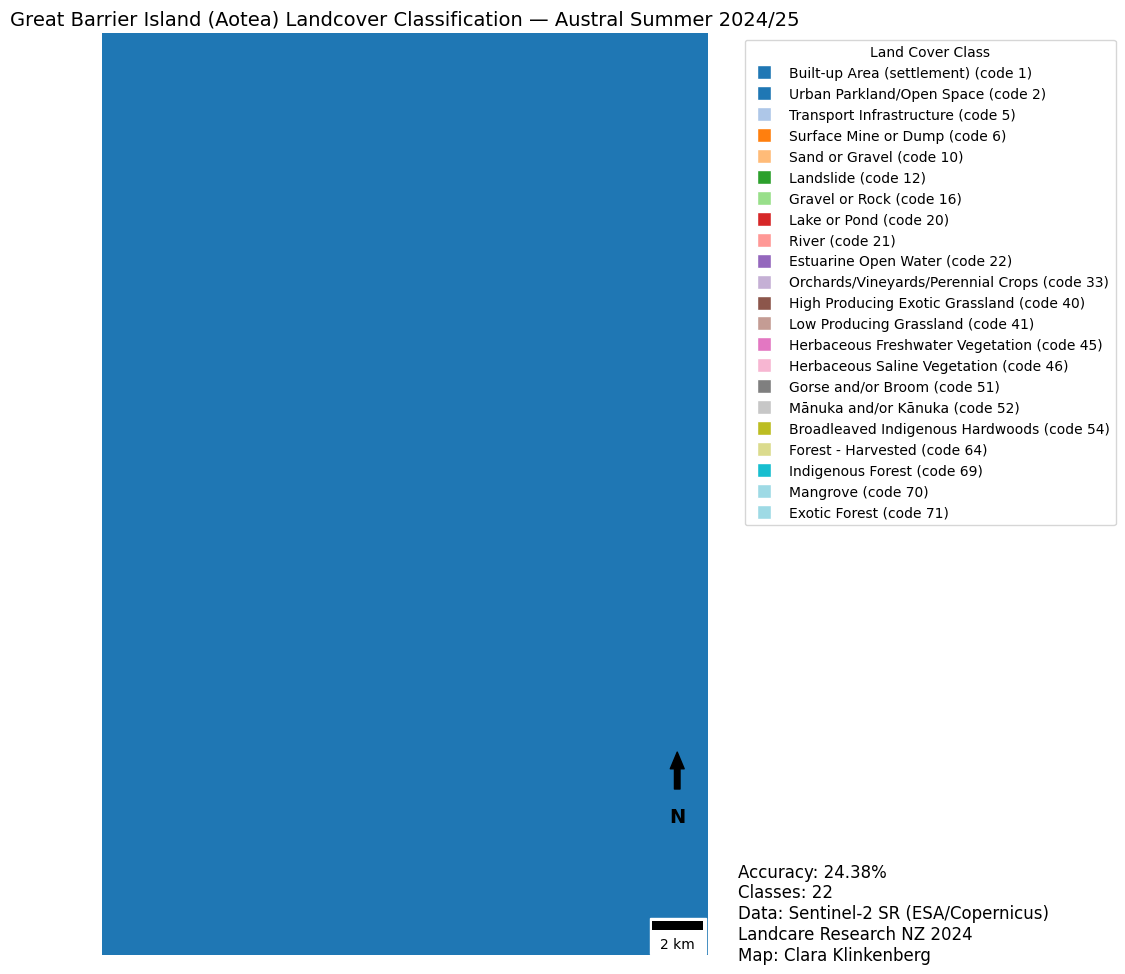

In [ ]:
import matplotlib.pyplot as plt
from rasterio.plot import show
import geopandas as gpd
from matplotlib_scalebar.scalebar import ScaleBar

# Load classified raster
with rasterio.open(output_classified) as src:
    classified_data = src.read(1)
    transform = src.transform
    crs = src.crs

# Map class colors (choose visually distinct palette)
colors = plt.cm.get_cmap('tab20', len(le.classes_))
class_colors = {i: colors(i) for i in range(len(le.classes_))}

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(classified_data, cmap=colors, interpolation='nearest')

# LCDB v5 class code → descriptive name mapping (only including your model's classes)
code_to_name = {
    '1':  "Built-up Area (settlement)",
    '2':  "Urban Parkland/Open Space",
    '5':  "Transport Infrastructure",
    '6':  "Surface Mine or Dump",
    '10': "Sand or Gravel",
    '12': "Landslide",
    '16': "Gravel or Rock",
    '20': "Lake or Pond",
    '21': "River",
    '22': "Estuarine Open Water",
    '33': "Orchards/Vineyards/Perennial Crops",
    '40': "High Producing Exotic Grassland",
    '41': "Low Producing Grassland",
    '45': "Herbaceous Freshwater Vegetation",
    '46': "Herbaceous Saline Vegetation",
    '51': "Gorse and/or Broom",
    '52': "Mānuka and/or Kānuka",
    '54': "Broadleaved Indigenous Hardwoods",
    '64': "Forest - Harvested",
    '69': "Indigenous Forest",
    '70': "Mangrove",
    '71': "Exotic Forest"
}

# Create legend labels mapping encoded index -> descriptive name
legend_labels = {
    i: code_to_name[str(le.classes_[i])]  # convert numeric code to string for lookup
    for i in range(len(le.classes_))
}

# Build legend handles
handles = [
    plt.Line2D([0], [0], marker='s', color='w',
               label=f"{legend_labels[i]} (code {le.classes_[i]})",
               markerfacecolor=class_colors[i], markersize=10)
    for i in range(len(le.classes_))
]

ax.legend(handles=handles, title="Land Cover Class", bbox_to_anchor=(1.05, 1), loc='upper left')

# North arrow (no idea how to make the thing point towardds north but I just assume that north is upwards, nothing to tweak for the scope of this lab)
ax.annotate('N',
            xy=(0.95, 0.15), xycoords='axes fraction',
            fontsize=14, fontweight='bold', ha='center', va='center')
ax.annotate('',
            xy=(0.95, 0.22), xycoords='axes fraction',
            xytext=(0.95, 0.18), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=4, headwidth=10))

# --- Model performance text ---
accuracy_percent = accuracy * 100
stats_text = (
    f"Accuracy: {accuracy_percent:.2f}%\n"
    f"Classes: {len(le.classes_)}"
)

# --- Data attribution text ---
attribution_text = (
    "Data: Sentinel-2 SR (ESA/Copernicus)\n"
    "Landcare Research NZ 2024\n"
    "Map: Clara Klinkenberg"
)

# Combine both blocks (stats on top, attribution below)
info_block = stats_text + "\n" + attribution_text

# Position the text just below the legend box
ax.text(1.05, 0.1, info_block,
        transform=ax.transAxes,
        fontsize=12, va='top', ha='left')

# Add scale bar
scalebar = ScaleBar(dx=10, units="m", location='lower right')  # 10 m pixels
ax.add_artist(scalebar)


ax.set_title("Great Barrier Island (Aotea) Landcover Classification — Austral Summer 2024/25", fontsize=14)
ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
!pip install matplotlib_scalebar